# Importing packages

In [1]:
# Installing the required packages
!pip install transformers datasets evaluate accelerate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00


In [2]:
# Standard library imports
import warnings

# Third-party imports
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datasets import load_dataset
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, ToTensor
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    DefaultDataCollator,
    Trainer,
    TrainingArguments,
    logging,
    pipeline,
)

# Disabling warnings
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

# Loading the MRI dataset

In [3]:
# Loading the dataset from Hugging Face Hub
mri_data = load_dataset("Falah/Alzheimer_MRI", split="train")

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [4]:
# Splitting the data into training and validation sets
mri_data_split = mri_data.train_test_split(
    test_size=0.2,
    stratify_by_column="label",
    seed=12345,
)
mri_data_split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4096
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1024
    })
})

# Data analysis

In [5]:
labels = mri_data_split["train"].features["label"].names
labels

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [6]:
# Computing the numbers of examples for each class (train/validation)
class_counts_train = np.bincount(mri_data_split["train"]["label"])
class_counts_valid = np.bincount(mri_data_split["test"]["label"])

# Creating a summary DataFrame
dataset_info = {
    "train": class_counts_train,
    "test": class_counts_valid
}
class_counts_info = pd.DataFrame(data=dataset_info, index=labels)
class_counts_info

train  test
Mild_Demented         579   145
Moderate_Demented      39    10
Non_Demented         2053   513
Very_Mild_Demented   1425   356

In [7]:
last_example = mri_data_split["train"][-1]
last_example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128>,
 'label': 3}

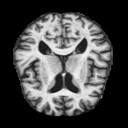

In [8]:
last_image = mri_data_split["train"]["image"][-1]
last_image

In [9]:
last_label = labels[last_example["label"]]
last_label

'Very_Mild_Demented'

# Preprocessing images

In [10]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [11]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [12]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [13]:
mri_data_split = mri_data_split.with_transform(transforms)
mri_data_split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4096
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1024
    })
})

In [14]:
data_collator = DefaultDataCollator()

# Loading the model

In [15]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [16]:
label2id

{'Mild_Demented': '0',
 'Moderate_Demented': '1',
 'Non_Demented': '2',
 'Very_Mild_Demented': '3'}

In [17]:
id2label

{'0': 'Mild_Demented',
 '1': 'Moderate_Demented',
 '2': 'Non_Demented',
 '3': 'Very_Mild_Demented'}

In [18]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Configuring the Trainer

In [19]:
class_weights = 1 - (class_counts_train / len(mri_data_split["train"]))
class_weights

array([0.85864258, 0.99047852, 0.4987793 , 0.65209961])

In [20]:
class_weights = torch.from_numpy(class_weights).float().to("cuda")
class_weights

tensor([0.8586, 0.9905, 0.4988, 0.6521], device='cuda:0')

In [21]:
mri_data_split = mri_data_split.rename_column("label", "labels")
mri_data_split

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 4096
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 1024
    })
})

In [22]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [23]:
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

In [24]:
batch_size = 64
logging_steps = len(mri_data_split["train"]) // batch_size
logging_steps

64

In [25]:
training_args = TrainingArguments(
    output_dir="alz-mri-vit",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    gradient_checkpointing=True,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=logging_steps,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.01,
    disable_tqdm=False,
    push_to_hub=True,
)

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mri_data_split["train"],
    eval_dataset=mri_data_split["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

TrainOutput(global_step=1920, training_loss=0.3936845714847247, metrics={'train_runtime': 2362.4807, 'train_samples_per_second': 52.013, 'train_steps_per_second': 0.813, 'total_flos': 9.52238637305561e+18, 'train_loss': 0.3936845714847247, 'epoch': 30.0})

In [26]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/spolivin/alz-mri-vit/commit/b2b0ecb84e796d5b50af69bcf0e3ebddfce7672b', commit_message='End of training', commit_description='', oid='b2b0ecb84e796d5b50af69bcf0e3ebddfce7672b', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [27]:
mri_data_test = load_dataset("Falah/Alzheimer_MRI", split="test")

In [28]:
id = -9
image = mri_data_test["image"][id]
print(id2label[str(mri_data_test["label"][id])])

Mild_Demented


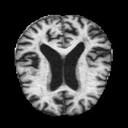

In [29]:
image

In [30]:
classifier = pipeline("image-classification", model="alz-mri-vit/checkpoint-1920")
classifier(image)

[{'score': 0.9944379329681396, 'label': 'Mild_Demented'},
 {'score': 0.0023822528310120106, 'label': 'Moderate_Demented'},
 {'score': 0.0016200037207454443, 'label': 'Non_Demented'},
 {'score': 0.0015596540179103613, 'label': 'Very_Mild_Demented'}]

In [31]:
mri_data_test = mri_data_test.with_transform(transforms)
mri_data_test

Dataset({
    features: ['image', 'label'],
    num_rows: 1280
})

In [32]:
predictions = trainer.predict(mri_data_test)

In [33]:
predictions

PredictionOutput(predictions=array([[-2.2871094 , -3.9707031 ,  1.1318359 ,  3.2558594 ],
       [ 3.8261719 , -2.0742188 , -2.3417969 ,  0.33911133],
       [-2.4882812 , -2.7617188 ,  4.8125    , -0.9682617 ],
       ...,
       [-1.0458984 , -2.5234375 , -1.9599609 ,  4.28125   ],
       [-1.7138672 , -2.0761719 ,  4.7070312 , -1.9384766 ],
       [-1.2529297 , -2.1699219 , -2.0234375 ,  4.3710938 ]],
      dtype=float32), label_ids=array([3, 0, 2, ..., 3, 2, 3]), metrics={'test_loss': 0.21619494259357452, 'test_f1': 0.9302622806094544, 'test_runtime': 10.0534, 'test_samples_per_second': 127.321, 'test_steps_per_second': 7.958})

In [34]:
preds = np.argmax(predictions.predictions, axis=-1)
test_f1 = f1_score(preds, predictions.label_ids, average="weighted")

print(f"Test f1-score: {test_f1:.4f}")

Test f1-score: 0.9307


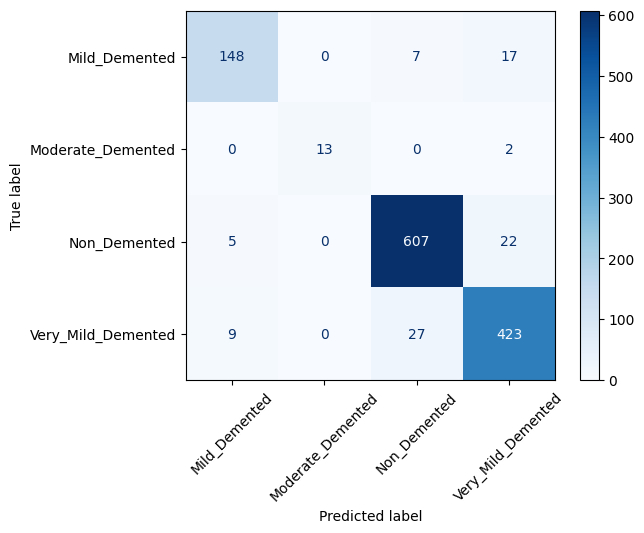

In [35]:
cm = confusion_matrix(y_true=predictions.label_ids, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()